In [9]:
%load_ext autoreload
%aimport lib
%aimport constants
%autoreload 1

import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
dataset = load("IV")
# ACHTUNG
# FUCKING WITH THE DATA AHEAD
# YOU HAVE BEEN WARNED
dataset = [dataset[0]] + dataset[4:]

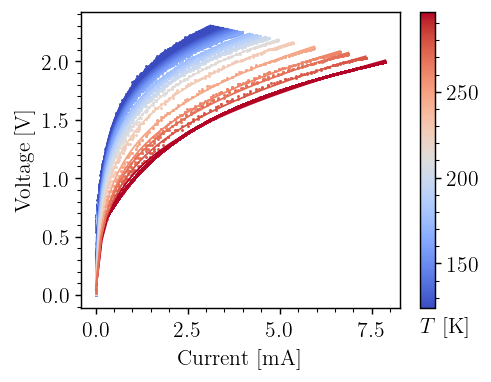

In [25]:
%matplotlib inline
all_params = np.zeros((len(dataset), 3))

temperatures = np.array([data.temperature for data in dataset])

cmap = plt.cm.coolwarm  # truncate_colormap(plt.cm.Plasma, 0.4, 1.0)
norm = mpl.colors.Normalize(vmin=temperatures.min(), vmax=temperatures.max())

fig, ax = plt.subplots()

for i, data in enumerate(dataset):
    color = cmap((data.temperature / temperatures.max() - 0.5) * 2)
    plt.scatter(data.I, data.V, color=color, marker='o', s=0.4)


    params, cov = sc.optimize.curve_fit(lambda I, I_s, n, R : curve_IV(I, data.temperature, I_s, n, R), 
                                        data.I[data.I > 0.15], data.V[data.I > 0.15],
                                        p0=(0.01, 100, 0.01),
                                        bounds=(0, np.inf)
                                        )
    all_params[i] = params
    x = np.linspace(data.I.min(), data.I.max())
    plt.plot(x, curve_IV(x, data.temperature, *params), c=color)                                 

cbar = fig.colorbar(plt.cm.ScalarMappable(norm, cmap), ax=ax)
cbar.ax.set_xlabel("$T$ [K]", loc='left')
plt.xlabel('Current [mA]')
plt.ylabel('Voltage [V]')
plt.grid(False)
plt.savefig("../figures/iv-curves.pdf")
plt.show()

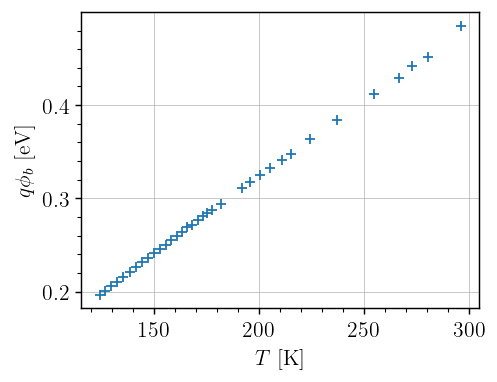

In [12]:
# Find phi_b
# I_S = A * A_G * T² * e^(-q phi_b / kT)
# => phi_b = -kT / q * ln(I_S / (T² A A_G))
# Or: 

I_s = all_params[:, 0]
phi_b_times_q = -sc.constants.k * temperatures * np.log(I_s / (A * A_G * temperatures**2))  # J
phi_b_times_q *= EV_PER_JOULE

plt.scatter(temperatures, phi_b_times_q)

# coefs = np.polyfit(temperatures, phi_b_times_q, 1)
# plt.plot(temperatures, np.poly1d(coefs)(temperatures))

plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$q \phi_b$ [eV]")
# So it's linear in temperature kinda
plt.savefig("../figures/iv-schottky-potential-temperature.pdf")

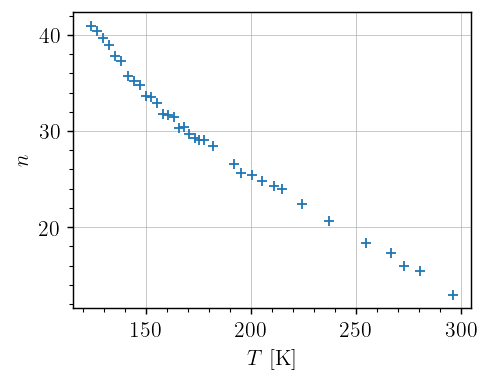

In [13]:
# Plot ideality
n = all_params[:, 1]
plt.scatter(temperatures, n)
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$n$")
plt.savefig("../figures/iv-ideality-factor.pdf")

Text(0, 0.5, '$R$ [$\\Omega$]')

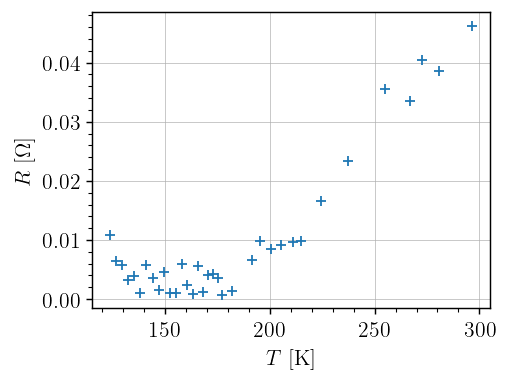

In [14]:
# Plot resistance
R = all_params[:, 2]
plt.scatter(temperatures, R)
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$R$ [$\Omega$]")

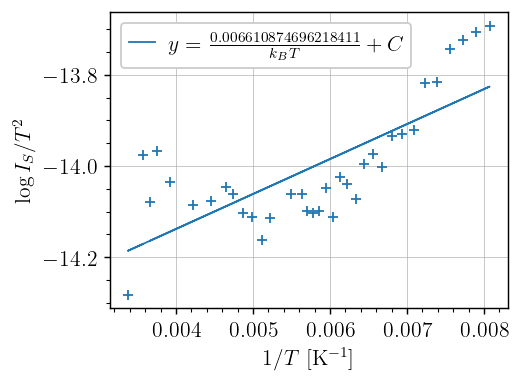

In [15]:
# Try extracting phi_b the other way [notice uuuuhhhh]
y = np.log(I_s / temperatures**2)
x = 1 / temperatures

coefs, cov = np.polyfit(x, y, 1, cov=True)
fitfunc = np.poly1d(coefs)
q_phi_b_over_kb = coefs[0]
phi_b_times_q_bis = q_phi_b_over_kb * sc.constants.k * EV_PER_JOULE

plt.scatter(x, y)
plt.plot(x, fitfunc(x), label=fr"$y = \frac{{{phi_b_times_q_bis}}}{{k_B T}} + C$")
plt.xlabel(r"$1/T$ [K$^{-1}$]")
plt.ylabel(r"$\log{I_S / T^2}$")
plt.legend()

q \phi_b = 1.5556369203474172 eV


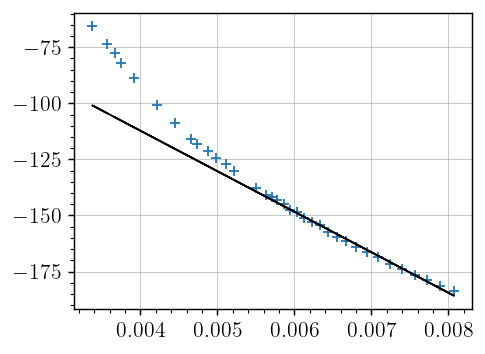

In [16]:
# %matplotlib inline
# Alternative way [rapport 2018]
# Modified Richardson Plot
y = n * np.log(I_s / temperatures**2 / A)
x = 1 / temperatures
# y = (I_s / temperatures**2 / A)
# x = 1 / temperatures / n


coefs, cov = np.polyfit(x[x > 0.0055], y[x > 0.0055], 1, cov=True)
fitfunc = np.poly1d(coefs)

phi_b_times_q_richardson = -coefs[0] * sc.constants.k * EV_PER_JOULE
print(fr"q \phi_b = {phi_b_times_q_richardson} eV")

plt.scatter(x, y)
plt.plot(x, fitfunc(x), c='k')